In [1]:
import h5py
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from heteromodes.eigentools import calc_eigenreconstruction
from heteromodes import EigenSolver
from heteromodes.utils import load_hmap
from neuromaps.datasets import fetch_fslr
import matplotlib.colors as mcolors
import nibabel as nib
from pathlib import Path

scaler = StandardScaler()

In [2]:
modesq = [5, 10, 20, 50, 100]

In [3]:
subj_ids = np.loadtxt(f"{PROJ_DIR}/data/empirical/subj_ids.txt", dtype=int)
with h5py.File(f"{PROJ_DIR}/data/empirical/HCP_unrelated-445_rfMRI_hemi-L_nsubj-50_parc-None_fsLR4k_hemi-L_BOLD.hdf5", "r") as f:
    medmask = np.array(f["medmask"][:], dtype=bool)
    bold = np.array(f["bold"][medmask, :, :])

FileNotFoundError: /fs04/kg98/vbarnes/HeteroModes/data/empirical/subj_ids.txt not found.

In [ ]:
hom_fc_corrs, het_fc_corrs = np.zeros((bold.shape[2], len(modesq))), np.zeros((bold.shape[2], len(modesq)))
hom_bold_corrs, het_bold_corrs = np.zeros((len(modesq), bold.shape[1], bold.shape[2])), np.zeros((len(modesq), bold.shape[1], bold.shape[2]))
for i, subj_id in enumerate(subj_ids):
    hcp_dir = f"/fs03/kg98/vbarnes/HCP/{subj_id}/MNINonLinear/Results"
    surf_file = f"{subj_id}.L.midthickness_MSMAll.4k_fs_LR.surf.gii"
    surf = f"{hcp_dir}/{surf_file}"
    bold_subj = scaler.fit_transform(bold[:, :, i].T).T

    # T1/T2 model
    hmap = nib.load(Path(hcp_dir, f"{subj_id}.L.SmoothedMyelinMap_BC.4k_fs_LR.func.gii")).darrays[0].data
    with h5py.File(f"{PROJ_DIR}/results/model_rest/individual/id-7/subj-{subj_id}/myelinmap_results.hdf5", "r") as f:
        alpha = f["best_combs"][0]
    solver2 = EigenSolver(surf, hmap, medmask, alpha=alpha)
    _, emodes2 = solver2.solve(n_modes=modesq[-1], fix_mode1=True, standardise=True)

    _, _, het_bold_corrs[:, :, i], _, het_fc_corrs[i, :] = calc_eigenreconstruction(
        bold_subj,
        emodes2,
        method="orthogonal",
        modesq=modesq,
        mass=solver2.mass,
        data_type="timeseries"
    )

    # Homogeneous model
    solver1 = EigenSolver(surf, hmap=None, medmask=medmask, alpha=0)
    _, emodes1 = solver1.solve(n_modes=modesq[-1], fix_mode1=True, standardise=True)

    _, _, hom_bold_corrs[:, :, i], _, hom_fc_corrs[i, :] = calc_eigenreconstruction(
        bold_subj, 
        emodes1,
        method="orthogonal",
        modesq=modesq,
        mass=solver1.mass,
        data_type="timeseries"
    )

IndexError: index 50 is out of bounds for axis 2 with size 50

## FC reconstruction accuracy

In [ ]:
def generate_shades(base_color, n, vmin=0.2, vmax=0.8):
    cmap = plt.get_cmap(base_color, 100)
    return [mcolors.to_hex(cmap(vmin + (vmax - vmin) * i / (n - 1))) for i in range(n)]

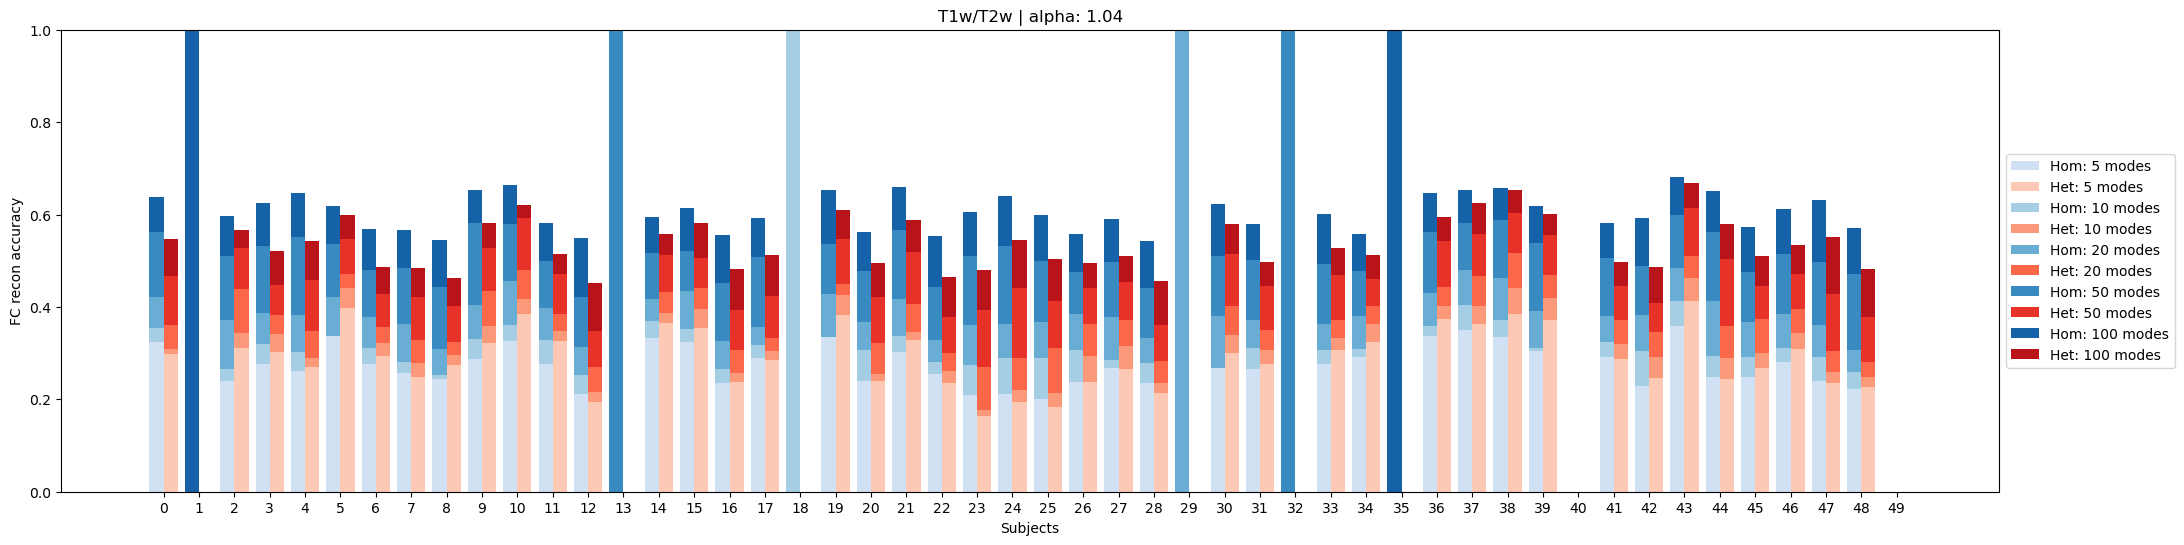

In [ ]:
# Generate colors dynamically
blues = generate_shades('Blues', len(modesq))  # Light to dark blue
reds = generate_shades('Reds', len(modesq))  # Light to dark red

fig, ax = plt.subplots(figsize=(25, 6))
x = np.arange(bold.shape[2])  # the label locations
width = 0.4  # the width of the bars

# Initialize bottom arrays
bottom_hom, bottom_het = 0, 0
# Generate stacked bar plot
for i, mode_id in enumerate(modesq):
    ax.bar(x - width/2, hom_fc_corrs[:, i] - bottom_hom, width=width, bottom=bottom_hom, label=f'Hom: {mode_id} modes', color=blues[i])
    ax.bar(x + width/2, het_fc_corrs[:, i] - bottom_het, width=width, bottom=bottom_het, label=f'Het: {mode_id} modes', color=reds[i])
    
    # Update bottom values for next iteration
    bottom_hom = hom_fc_corrs[:, i]
    bottom_het = het_fc_corrs[:, i]

# Labels and title
ax.set_xlabel('Subjects')
ax.set_ylabel('FC recon accuracy')
ax.set_title(f'T1w/T2w | alpha: {alpha}')
ax.set_xticks(x)
# ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylim(0, 1)

# Move legend outside to the right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show plot
plt.show()

## BOLD fMRI reconstruction accuracy (at each timepoint)

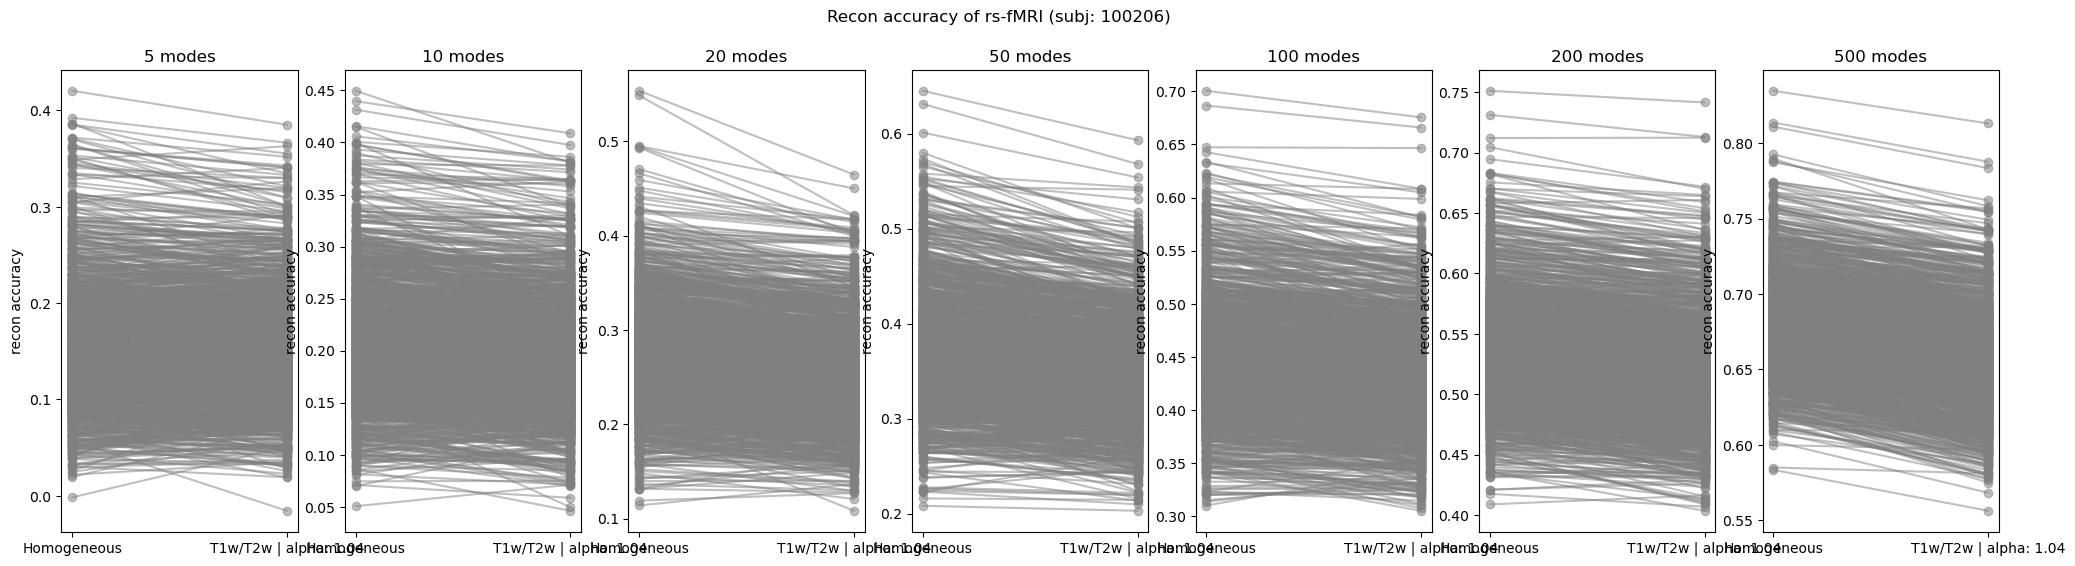

In [ ]:
fig, axs = plt.subplots(1, len(modesq), figsize=(25, 6))
axs = axs.flatten()

for i, mode_id in enumerate(modesq):
    for j in range(bold.shape[1]):
        axs[i].plot([1, 2], [hom_bold_corrs[i, j, 0], het_bold_corrs[i, j, 0]], marker='o', color='gray', alpha=0.5)

    axs[i].set_title(f'{mode_id} modes')
    axs[i].set_xticks([1, 2], ['Homogeneous', f'T1w/T2w | alpha: {alpha}'])
    axs[i].set_ylabel('recon accuracy')

plt.suptitle(f"Recon accuracy of rs-fMRI (subj: {subj_ids[0]})")
plt.show()